# PS reconstruction using linac phase

In [1]:
import matplotlib.pyplot as plt

import torch
from copy import deepcopy

import lightning as L

from gpsr.modeling import (
    LinacPhaseQuadDipoleLattice, 
    LinacVoltageQuadDipoleLattice,
    GPSR,
)

from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator

from cheetah.particles import ParticleBeam

In [2]:
load_beam = torch.load("example_data/example_distributions/complex_beam.pt", weights_only=False)
print(load_beam.particles.shape)
print(load_beam.energy)

torch.Size([10000, 7])
tensor(43363012.)


In [3]:
incoming_beam = ParticleBeam(
    particles=load_beam.particles,
    energy=load_beam.energy,
    particle_charges= torch.ones_like(load_beam.particles[:,0])*1.0,
    survival_probabilities=torch.ones_like(load_beam.particles[:,0]),
)

In [4]:
# # initial beam:
# #twiss_params = {
#     'energy': torch.tensor(43.3e6),
#     'emittance_x': torch.tensor(1e-6),
#     'emittance_y': torch.tensor(1e-6),
#     'beta_x': torch.tensor(1.0),
#     'alpha_x': torch.tensor(0.0),
#     'beta_y': torch.tensor(1.0),
#     'alpha_y': torch.tensor(0.0),
#     'total_charge': torch.tensor(1e-9),
# }

# #incoming_beam = ParticleBeam.from_twiss(**twiss_params)
# incoming_beam = torch.load("example_data/example_distributions/complex_beam.pt", weights_only=False)
# print(incoming_beam.energy)
# print(incoming_beam.particle_charges.shape)
# print(incoming_beam.survival_probabilities)
# incoming_beam.particle_charges = torch.ones_like(incoming_beam.particle_charges) * 1e-9 / len(incoming_beam.particle_charges)




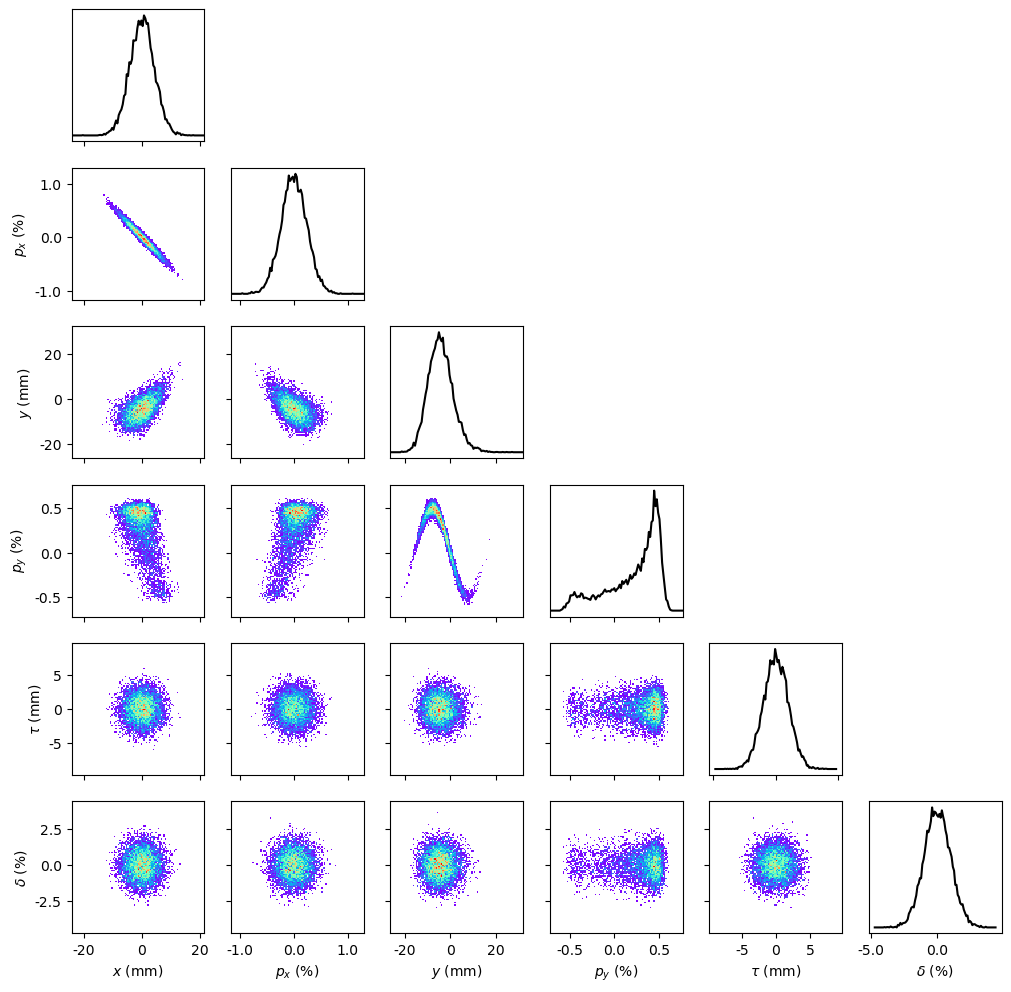

In [5]:
incoming_beam.plot_distribution()
plt.show()

In [6]:
n_pixels = 200
screen_size_mm = 50

lattice = LinacPhaseQuadDipoleLattice(
    l_linac=0.5,
    v_linac=15.0e6,
    f_linac=1.3e9,
    l_l_q=1.0,
    l_quad=0.11,
    k1_q1=0.0,
    l_q1_q2=0.2,
    k1_q2=0.0,
    l_q2_q3=0.2,
    k1_q3=0.0,
    l_q3_q4=0.2,
    l_q4_s1=1.0,
    l_s1_b=1.0,
    l_bend=0.3018,
    theta_bend=-20 * 3.14 / 180,
    l_b_s2=1.0,
    resolution_s1=(n_pixels, n_pixels),
    px_size_s1=screen_size_mm*1e-3 / n_pixels,
    resolution_s2=(n_pixels, n_pixels),
    px_size_s2=screen_size_mm*1e-3 / n_pixels
)

In [7]:
n_k1s = 5
n_phases = 5
k1s = torch.linspace(-10.0, 10.0, n_k1s) # in m^-2
#phases = 90.01+torch.linspace(-15, 15, n_phases) # in degrees
phases = 90+torch.linspace(-90, 90, n_phases) # in degrees

In [8]:
parameters = torch.stack(torch.meshgrid(phases, k1s), dim=-1)
parameters.shape

/opt/homebrew/Caskroom/miniforge/base/envs/gpsr/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1739474897993/work/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([5, 5, 2])

In [9]:
parameters

tensor([[[  0., -10.],
         [  0.,  -5.],
         [  0.,   0.],
         [  0.,   5.],
         [  0.,  10.]],

        [[ 45., -10.],
         [ 45.,  -5.],
         [ 45.,   0.],
         [ 45.,   5.],
         [ 45.,  10.]],

        [[ 90., -10.],
         [ 90.,  -5.],
         [ 90.,   0.],
         [ 90.,   5.],
         [ 90.,  10.]],

        [[135., -10.],
         [135.,  -5.],
         [135.,   0.],
         [135.,   5.],
         [135.,  10.]],

        [[180., -10.],
         [180.,  -5.],
         [180.,   0.],
         [180.,   5.],
         [180.,  10.]]])

In [10]:
lattice.set_lattice_parameters(parameters)

In [11]:
lattice.segment

Segment(elements=ModuleList(
  (0): Cavity(length=tensor(0.5000), voltage=tensor(15000000.), phase=tensor([[  0.,   0.,   0.,   0.,   0.],
          [ 45.,  45.,  45.,  45.,  45.],
          [ 90.,  90.,  90.,  90.,  90.],
          [135., 135., 135., 135., 135.],
          [180., 180., 180., 180., 180.]]), frequency=tensor(1.3000e+09), name='SCAN_LINAC')
  (1): Drift(length=tensor(0.6950), tracking_method='cheetah', name='unnamed_element_0')
  (2): Quadrupole(length=tensor(0.1100), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=5, tracking_method='bmadx', name='QUAD1')
  (3): Drift(length=tensor(0.0900), tracking_method='cheetah', name='unnamed_element_1')
  (4): Quadrupole(length=tensor(0.1100), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=5, tracking_method='bmadx', name='QUAD2')
  (5): Drift(length=tensor(0.0900), tracking_method='cheetah', name='unnamed_element_2')
  (6): Quadrupole(length=tensor(0.1100), k1=tensor(0.), misalig

In [12]:
observed_screens = lattice.track_and_observe(incoming_beam)

torch.Size([5, 5])
tensor([[58363004., 58363004., 58363004., 58363004., 58363004.],
        [53969616., 53969616., 53969616., 53969616., 53969616.],
        [43363012., 43363012., 43363012., 43363012., 43363012.],
        [32756410., 32756410., 32756410., 32756410., 32756410.],
        [28363012., 28363012., 28363012., 28363012., 28363012.]])


In [13]:
len(observed_screens)

2

In [14]:
observed_screens[0].shape

torch.Size([5, 5, 200, 200])

In [15]:
def run_sim(lattice, incoming_beam, k1_q1, k1_q2, k1_q3):
    lattice.segment.QUAD1.kl = k1_q1
    lattice.segment.QUAD2.kl = k1_q2
    lattice.segment.QUAD3.kl = k1_q3
    return lattice.track_and_observe(incoming_beam)

In [16]:
n_pixels = 200
screen_size_mm = 50

lattice = LinacPhaseQuadDipoleLattice(
    l_linac=0.5,
    v_linac=15.0e6,
    f_linac=1.3e9,
    l_l_q=1.0,
    l_quad=0.11,
    k1_q1=0.0,
    l_q1_q2=0.2,
    k1_q2=0.0,
    l_q2_q3=0.2,
    k1_q3=0.0,
    l_q3_q4=0.2,
    l_q4_s1=1.0,
    l_s1_b=1.0,
    l_bend=0.3018,
    theta_bend=-20 * 3.14 / 180,
    l_b_s2=1.0,
    resolution_s1=(n_pixels, n_pixels),
    px_size_s1=screen_size_mm*1e-3 / n_pixels,
    resolution_s2=(n_pixels, n_pixels),
    px_size_s2=screen_size_mm*1e-3 / n_pixels
)

n_k1s = 5
n_phases = 5
k1s = torch.linspace(-10.0, 10.0, n_k1s) # in m^-2
#phases = 90.01+torch.linspace(-15, 15, n_phases) # in degrees
phases = 90.01+torch.linspace(-90, 90, n_phases) # in degrees
parameters = torch.stack(torch.meshgrid(phases, k1s), dim=-1)
lattice.set_lattice_parameters(parameters)

observed_screens = run_sim(lattice, incoming_beam, 0.0, 0.0, 0.0)

torch.Size([5, 5])
tensor([[58363004., 58363004., 58363004., 58363004., 58363004.],
        [53967760., 53967760., 53967760., 53967760., 53967760.],
        [43360388., 43360388., 43360388., 43360388., 43360388.],
        [32754556., 32754556., 32754556., 32754556., 32754556.],
        [28363012., 28363012., 28363012., 28363012., 28363012.]])


In [17]:
def plot_observations(observations):
    fig, ax = plt.subplots(nrows=n_phases, ncols=n_k1s, figsize=(n_k1s*4, n_phases*4))
    for i in range(n_phases):
        for j in range(n_k1s):
            ax[i,j].imshow(observed_screens[0][i,j].numpy())
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    fig.tight_layout()
    plt.show()
    fig, ax = plt.subplots(nrows=n_phases, ncols=n_k1s, figsize=(n_k1s*4, n_phases*4))
    for i in range(n_phases):
        for j in range(n_k1s):
            ax[i,j].imshow(observed_screens[1][i,j].numpy())
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    fig.tight_layout()
    plt.show()

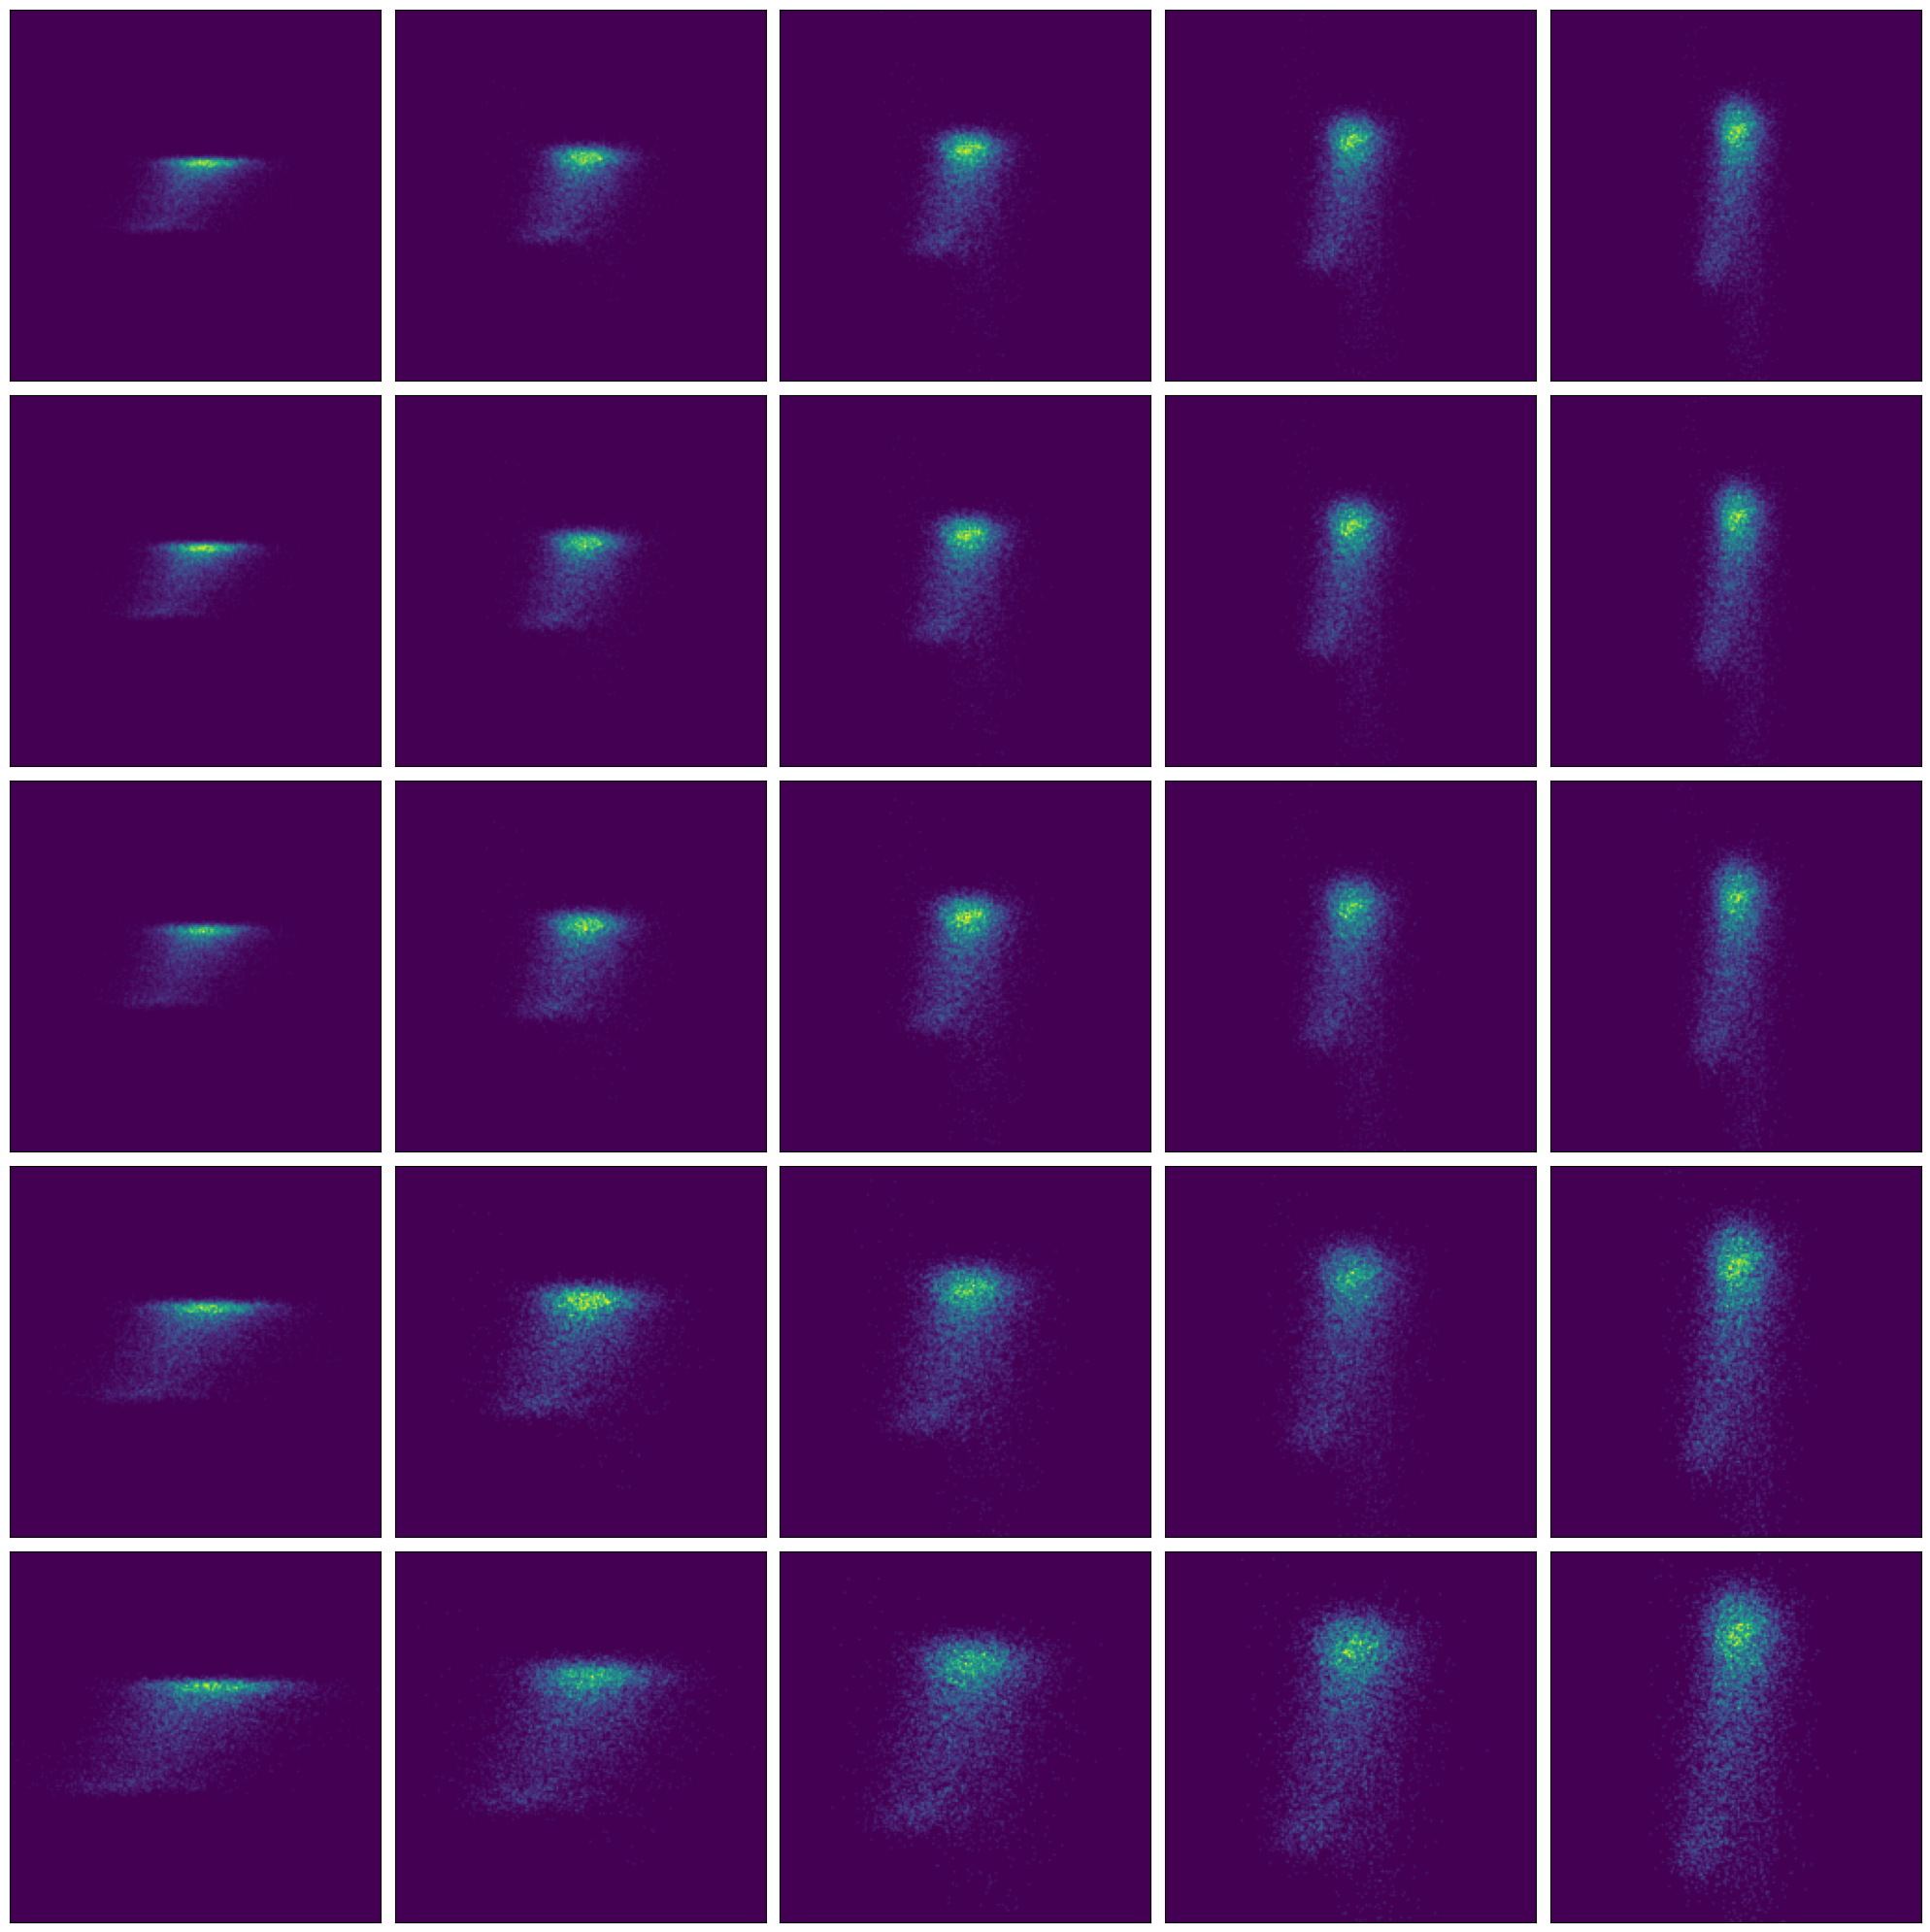

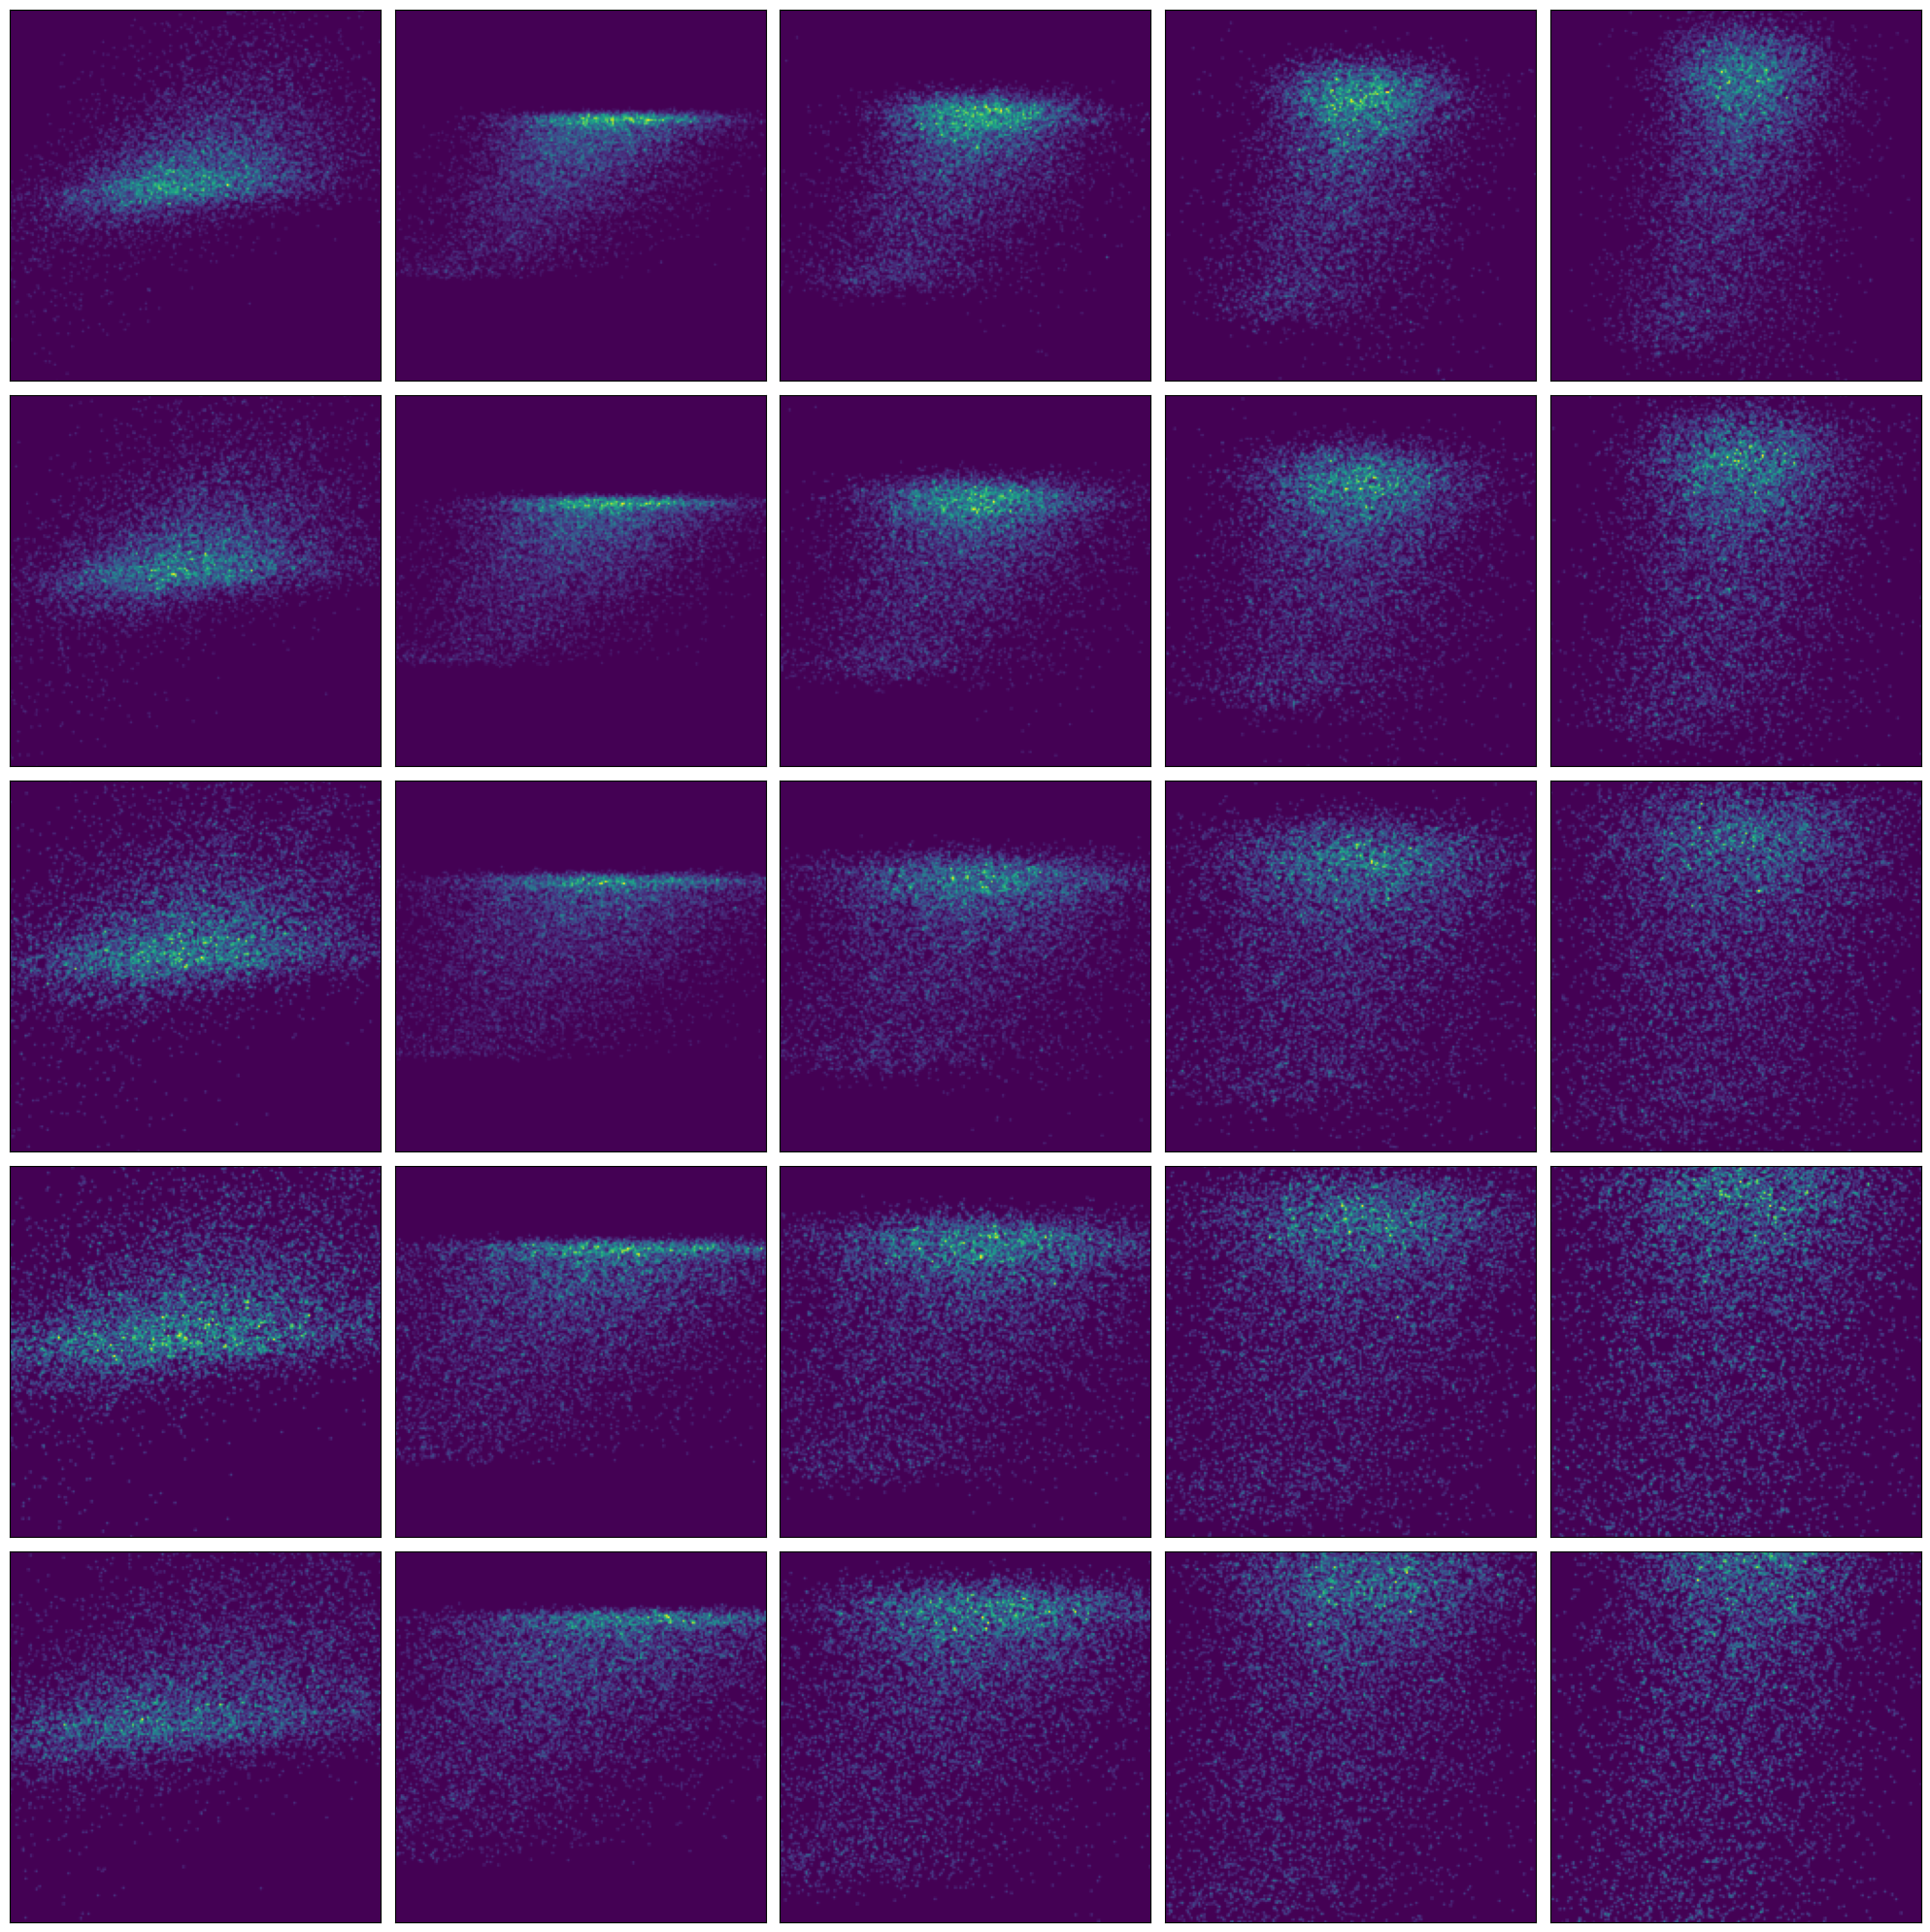

In [18]:
plot_observations(observed_screens)

In [19]:
import xopt